In [6]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use("ggplot")

%matplotlib inline

In [7]:
print(tf.__version__)

2.7.0


# 데이터 탐색

In [41]:
main_folder = 'C:/workspace/dataset/CelebFaces-Attributes(CelebA)Dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000505.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

## Load the attributes of every pic

In [16]:
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
# EXAMPLE_PIC에 설정했던 '000505.jpg' 확인
df_attr.loc[df_attr.image_id == '000505.jpg']

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
504,000505.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,1,-1,-1,-1,-1,1


In [17]:
df_attr.set_index('image_id', inplace = True)  # 'image_id' 칼럼을 인덱스로 만들어주고
df_attr.replace(to_replace = -1, value = 0, inplace = True) # '-1' 값을 '0' 으로 수정
df_attr.shape

(202599, 40)

## 사용할 수 있는 attribute 확인

In [18]:
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


## EXAMPLE_PIC 확인
- `178 x 218` px

Smiling    1
Male       0
Young      1
Name: 000505.jpg, dtype: int64

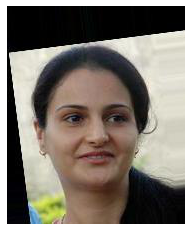

In [19]:
img = load_img(EXAMPLE_PIC)
plt.grid()
plt.imshow(img)
plt.axis('off')
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling', 'Male', 'Young']]

## attribute 분포 확인
- 데이터셋의 성비를 확인해보자

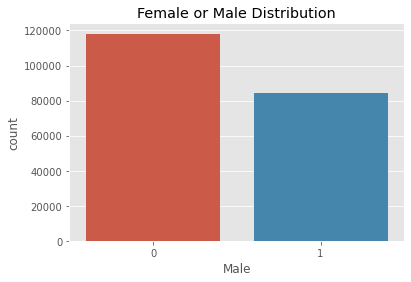

In [25]:
plt.title('Female or Male Distribution')
sns.countplot(x = 'Male', data = df_attr)
plt.show()

## 여성 데이터가 더 많다

# Train, Validation, Test 데이터 나누기
- 추천하는 비율
    - [0 : 162770] : Train
    - [1662771 : 182637] : Validation
    - [182638 : 202599] : Test
- 이는 데이터 제공자가 추천하는 비율로 [Source](https://www.kaggle.com/jessicali9530/celeba-dataset)에 설명이 나와있습니다.
- `list_eval_partition.csv` 에 나와있습니다.
- 그러나, 시간이 너무 오래걸리기때문에 다음과 같은 수로 데이터셋을 나눌겁니다.
    - Train : 20000
    - Validation : 5000
    - Test : 5000

In [26]:
df_part = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_part.head()

# 0 -> Training
# 1 -> VAlidation
# 2 -> Test

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [27]:
df_part['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

## 해당 데이터프레임의 Partition 부분에 Male 정보를 합쳐보자

In [32]:
df_part = df_part.set_index('image_id')
df_tmp = df_attr[['Male']]

df_part_attr = pd.concat([df_part, df_tmp], axis = 1)
df_part_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


## Generate Partitions ( Train, Validation, Test )
- 모델에 있어서 좋은 성능을 내게하기위해 이미지의 수를 밸런스하게 맞춰줄 필요가 있다.
- [링크](https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf)에 보다시피 좋은 성능을 낼 수 없게된다.
- 함수를 만들어 각 partition에 만들어주자

In [66]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img) / 255.0
    x = x.reshape((1, ) + x.shape)
    
    return x

def generate_df(partition, attr, num_samples):
    df_ = df_part_attr[(df_part_attr['partition'] == partition) & (df_part_attr[attr] == 0)].sample(int(num_samples / 2))
    df_ = pd.concat([df_, df_part_attr[(df_part_attr['partition'] == partition) & (df_part_attr[attr] == 1)].sample(int(num_samples / 2))])
    
    # Train / Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr], 2)
    # Test
    else:
        x_ = []
        y_ = []
        
        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis = 0)
            x_.append(im)
            y_.append(target[attr])
            
    return x_, y_

# 이미지 전처리 : 데이터 Augmentation
- 모델은 다양한 변수들을 학습할 것. (각도 변화, 사이즈, 위치 등) >> 이러한 증강을 통해 모델은 처음보는 이미지에 대해 학습할 것

## Data Augmentation

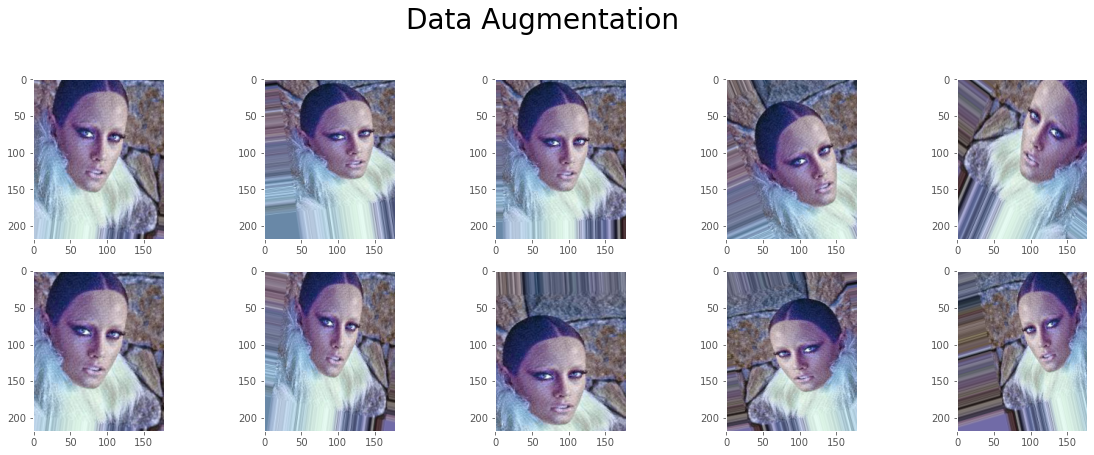

In [44]:
datagen = ImageDataGenerator(rotation_range = 30,
                            width_shift_range = .2,
                            height_shift_range = .2,
                            shear_range = .2,
                            zoom_range = .2,
                            horizontal_flip = True)

# 1개의 이미지를 불러오고 size 재조정 해보자
EXAMPLE_PIC = images_folder + '000405.jpg'
img = load_img(EXAMPLE_PIC)
x = img_to_array(img) / 255.0
x = x.reshape((1, ) + x.shape)

# 10개 출력
plt.figure(figsize = (20, 10))
plt.suptitle('Data Augmentation', fontsize = 28)

i = 0
for batch in datagen.flow(x,  batch_size = 1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

## Build Data Generators

In [46]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 30,
                                  width_shift_range = .2,
                                  height_shift_range = .2,
                                  shear_range = .2,
                                  zoom_range = .2,
                                  horizontal_flip = True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size = BATCH_SIZE)

In [56]:
# Validation
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(x_valid, y_valid)

# Build the Model 

## Set the Model

In [57]:
inc_model = InceptionV3(weights = 'C:/workspace/dataset/CelebFaces-Attributes(CelebA)Dataset/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                       include_top = False,
                       input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

print('number of layers: ', len(inc_model.layers))
inc_model.summary()

number of layers:  311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 108, 88, 32)  864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 108, 88, 32)  96         ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                

### Inception-V3 model 구조
![ㅇㅇ](https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png)

- top layer에 classification이 없어서 layer를 조금 추가해주자

In [58]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
pred = Dense(2, activation = 'softmax')(x)

### 새로운 Top Layer들
![ㅇㄴㄹ](https://i.imgur.com/rWF7bRY.png)

In [59]:
# 최종 모델 
model_ = Model(inputs = inc_model.input, outputs = pred)

for layer in model_.layers[:52]:
    layer.trainable = False
    
# compile
model_.compile(optimizer = SGD(lr = 0.0001,
                              momentum = .9),
                              loss = 'categorical_crossentropy',
                              metrics = ['acc'])

C:\Users\User\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Model 학습

In [60]:
checkpointer = ModelCheckpoint(filepath = 'weights.best.inc.male.hdf5', 
                              verbose = 1,
                              save_best_only = True)

In [61]:
hist = model_.fit_generator(train_generator,
                           validation_data = (x_valid, y_valid),
                           steps_per_epoch = TRAINING_SAMPLES / BATCH_SIZE,  ## steps_per_epoch = 훈련 샘플 수 / 배치 사이즈
                           epochs = NUM_EPOCHS,
                           callbacks = [checkpointer],
                           verbose = 1)

C:\Users\User\AppData\Local\Temp/ipykernel_13324/428250905.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator,


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.6390 - acc: 0.6245
Epoch 00001: val_loss improved from inf to 0.73929, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 53s 79ms/step - loss: 0.6390 - acc: 0.6245 - val_loss: 0.7393 - val_acc: 0.5715
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.5024 - acc: 0.7519
Epoch 00002: val_loss improved from 0.73929 to 0.70311, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 49s 79ms/step - loss: 0.5024 - acc: 0.7519 - val_loss: 0.7031 - val_acc: 0.5920
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.4340 - acc: 0.7935
Epoch 00003: val_loss did not improve from 0.70311
625/625 [==============================] - 48s 77ms/step - loss: 0.4340 - acc: 0.7935 - val_loss: 0.8374 - val_acc: 0.5580
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.4003 - acc: 0.8205
Epoch 00004: val_loss 

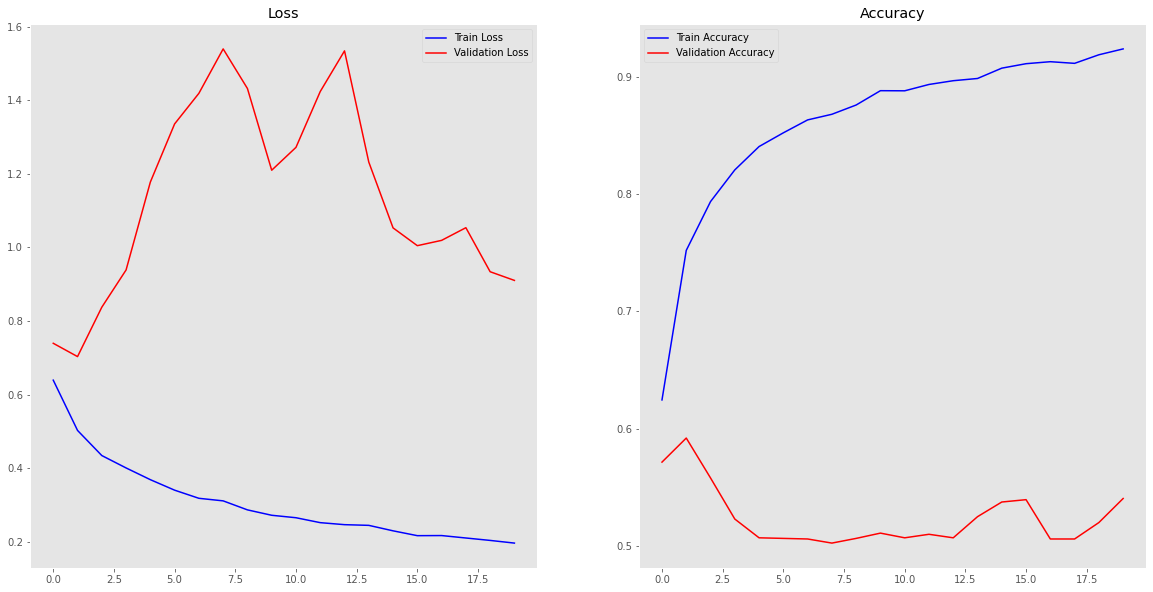

In [63]:
plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'b-', label = 'Train Loss')
plt.plot(hist.history['val_loss'], 'r-', label = 'Validation Loss')
plt.grid()
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], 'b-', label = 'Train Accuracy')
plt.plot(hist.history['val_acc'], 'r-', label = 'Validation Accuracy')
plt.grid()
plt.title('Accuracy')
plt.legend()

plt.show()

## 모델 평가

In [64]:
model_.load_weights('weights.best.inc.male.hdf5')

In [68]:
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

model_pred = [np.argmax(model_.predict(feature)) for feature in x_test]

test_acc = 100 * np.sum(np.array(model_pred) == y_test) / len(model_pred)

print(test_acc)
print(f1_score(y_test, model_pred))

56.35
0.5650224215246636


In [69]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [70]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    


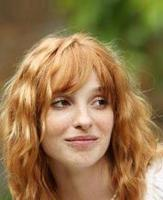


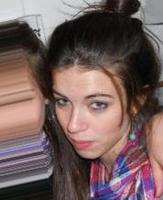


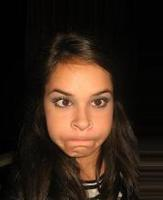


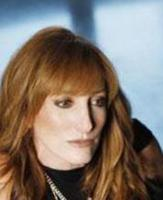


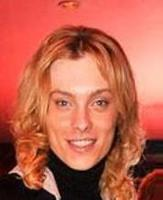


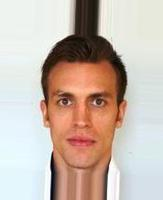


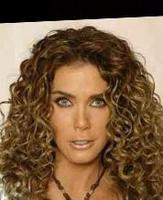


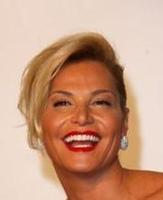

In [72]:
#select random images of the test partition
df_to_test = df_part_attr[(df_part_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])